In [1]:
%config Completer.use_jedi = False
#own imports
import preprocessing
import featuresExtration

#third imports
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.svm import LinearSVC

dir_data = "./apnea-ecg-database-1.0.0"
dir_data_training = "./processed/train/"
dir_data_testing = "./processed/test/"
dir_feactures = "./feactures"

fs = 100
sample = fs * 60

filenames_train = [
        "a01", "a02", "a03", "a04", "a05", "a06", "a07", "a08", "a09", "a10",
        "a11", "a12", "a13", "a14", "a15", "a16", "a17", "a18", "a19", "a20",
        "b01", "b02", "b03", "b04", "b05",
        "c01", "c02", "c03", "c04", "c05", "c06", "c07", "c08", "c09", "c10"
    ]

filename_test = [
        "x01", "x02", "x03", "x04", "x05", "x06", "x07", "x08", "x09", "x10",
        "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20",
        "x21", "x22", "x23", "x24", "x25", "x26", "x27", "x28", "x29", "x30",
        "x31", "x32", "x33", "x34", "x35"
    ]


# Preprocessing

In [ ]:
for i in range(len(filenames_train)):
    pathtoFile = os.path.join(dir_data, filenames_train[i])
    result = preprocessing.processingData(pathtoFile, sample, fs)
    
    if not os.path.exists(dir_data_training):
        os.makedirs(dir_data_training)
        
    with open(f'{dir_data_training}/{filenames_train[i]}.pkl', 'wb') as file:
        pickle.dump(result, file)

In [ ]:
answers = {}

with open(os.path.join(dir_data, "test-dataset-annos"), "r") as f:
    for answer in f.read().split("\n\n"):
        answers[answer[:3]] = list("".join(answer.split()[2::2]))

for i in range(len(filename_test)):
    labels = answers[filename_test[i]]
    pathtoFile = os.path.join(dir_data, filename_test[i])
    result = preprocessing.processingData(pathtoFile, sample, fs, labels=labels)
    
    if not os.path.exists(dir_data_testing):
        os.makedirs(dir_data_testing)
        
    with open(f'{dir_data_testing}/{filename_test[i]}.pkl', 'wb') as file:
        pickle.dump(result, file)


# Feactures extract

In [2]:
df_train = pd.DataFrame()

for i in range(len(filenames_train)):
    pathtoFile = os.path.join(dir_data_training, filenames_train[i]) + ".pkl"
    file = pd.read_pickle(pathtoFile)
    df_features = featuresExtration._calculate_features(file, filenames_train[i])
    
    df_train = df_train.append(df_features, ignore_index=True)

#Saving feactures file --- Train
if not os.path.exists(dir_feactures):
    os.makedirs(dir_feactures)
df_train.dropna(inplace=True)
df_train.to_csv(f'{dir_feactures}/FeaturesTrain.csv', index=False)

c10: 100%|█████████████████████████████| 424/424 [00:01<00:00, 234.86it/s]


In [3]:
df_test = pd.DataFrame()

for i in range(len(filename_test)):
    pathtoFile = os.path.join(dir_data_testing, filename_test[i]) + ".pkl"
    file = pd.read_pickle(pathtoFile)
    
    df_features = featuresExtration._calculate_features(file, filename_test[i])
    
    df_test = df_test.append(df_features, ignore_index=True)

#Saving feactures file --- Test
if not os.path.exists(dir_feactures):
    os.makedirs(dir_feactures)
df_test.dropna(inplace=True)
df_test.to_csv(f'{dir_feactures}/FeaturesTest.csv', index=False)

x35: 100%|█████████████████████████████| 477/477 [00:01<00:00, 240.34it/s]


# Feactures Selection

In [2]:
from sklearn.feature_selection import SelectKBest , chi2
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

df_train = pd.read_csv(f'{dir_feactures}/FeaturesTrain.csv')
df_test = pd.read_csv(f'{dir_feactures}/FeaturesTest.csv')

df_temp = df_test.drop(['apn'], axis=1)

corr = df_temp.corr()
corr = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(np.bool))

<AxesSubplot:>

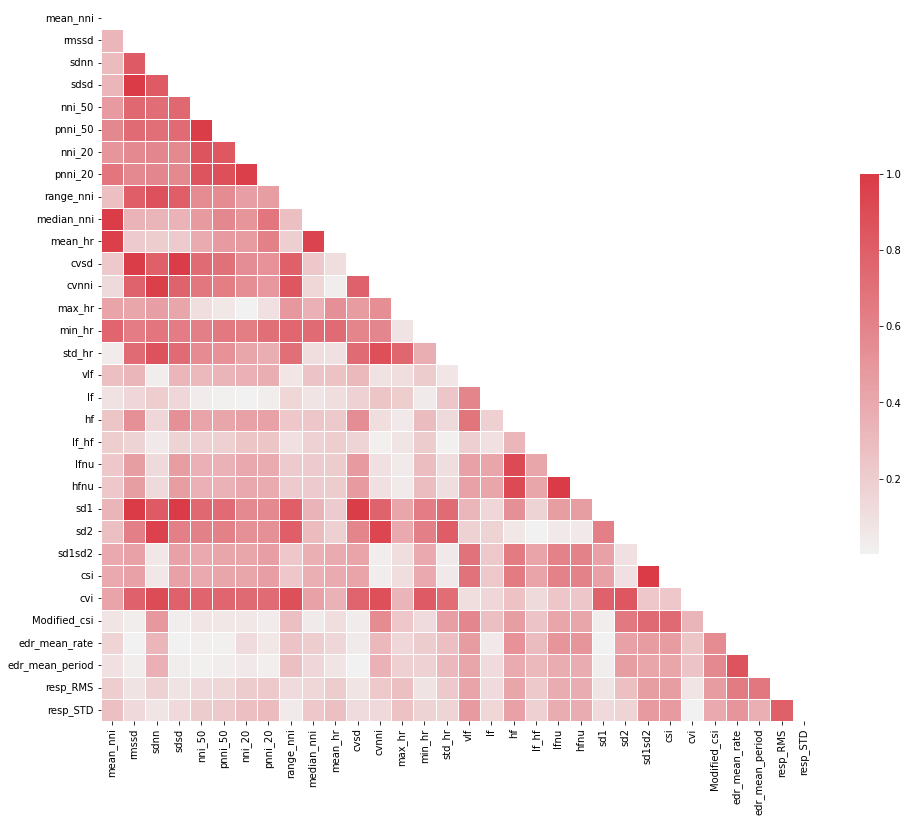

In [3]:
f, ax = plt.subplots(figsize=(16, 14))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr.abs(), cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:
to_drop = [column for column in corr.columns if any(corr.abs()[column] > 0.98)]
df_train = df_train.drop(to_drop, axis=1)
df_test = df_test.drop(to_drop, axis=1)

In [5]:
#Train Data preparation
#Normalização
apn_train = df_train['apn']
df_train_n_apn = df_train.drop(['apn'], axis=1)
df_train_n_apn = (df_train_n_apn - df_train_n_apn.mean()) / df_train_n_apn.std()

#Test Data preparation
apn_test = df_test['apn']
df_test_n_apn = df_test.drop(['apn'], axis=1)
df_test_n_apn = (df_test_n_apn - df_test_n_apn.mean()) / df_test_n_apn.std()


In [6]:
#model0 = SelectKBest(chi2, k=10).fit_transform(df_train_n_apn, apn_train)

model1 = ExtraTreesClassifier(n_estimators=50)
model1.fit(df_train_n_apn, apn_train)

model = SelectFromModel(model1, prefit=True)
X_train = model.transform(df_train_n_apn)
X_test = model.transform(df_test_n_apn)

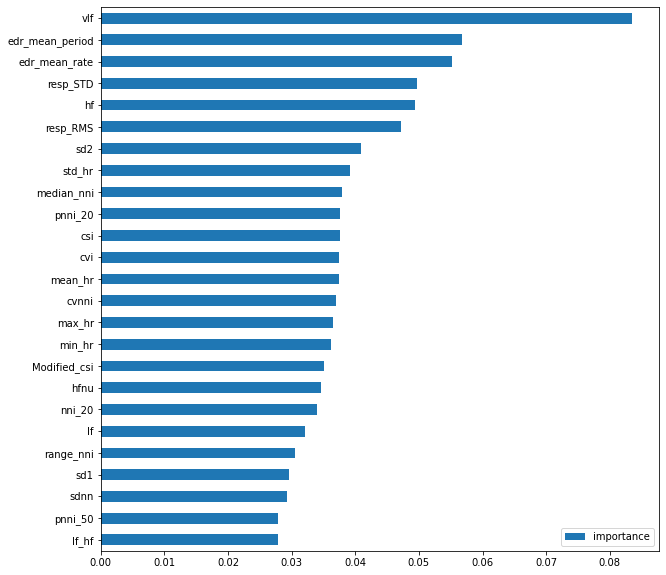

In [7]:
temp = pd.DataFrame(data=model1.feature_importances_, index=df_train_n_apn.columns, columns=['importance'])
ax = temp.sort_values('importance').plot.barh(figsize=(10,10))

In [8]:
temp = pd.DataFrame(data=model2.feature_importances_, index=df_train_n_apn.columns, columns=['importance'])
ax = temp.sort_values('importance').plot.barh(figsize=(10,10))

NameError: name 'model2' is not defined

# Classification

In [13]:
from sklearn.neural_network import MLPClassifier

model2 = RandomForestClassifier(random_state=0)
model2.fit(X_train, apn_train)

model3 = LinearSVC(random_state=0, tol=1e-5)
model3.fit(X_train, apn_train)

model4 = MLPClassifier(hidden_layer_sizes=(X_train.shape[1] * 2 + 1,), alpha=1, max_iter=1000)
model4.fit(X_train, apn_train)

MLPClassifier(alpha=1, hidden_layer_sizes=(15,), max_iter=1000)

In [24]:
print(model2.predict(X_test))

print(apn_test)

[0. 0. 1. ... 0. 0. 0.]
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
16728    0.0
16729    0.0
16730    0.0
16731    0.0
16732    0.0
Name: apn, Length: 16733, dtype: float64


In [20]:
print(model2.score(X_test, apn_test))
print(model3.score(X_test, apn_test))
print(model4.score(X_test, apn_test))

1.0
0.7565290145222017
0.7544971015358871
0.7702145461064962


In [19]:
y_pred = model1.predict(X_test)
C = confusion_matrix(apn_test, y_pred, labels=(1, 0))
TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
print("acc: {}, sn: {}, sp: {}".format(acc, sn, sp))

disp = ConfusionMatrixDisplay(confusion_matrix=C, display_labels=model1.classes_)
disp.plot()

ValueError: X has 7 features, but ExtraTreeClassifier is expecting 25 features as input.

# testes

In [ ]:
import neurokit2 as nk
from scipy.signal import detrend, find_peaks
from hrv.classical import frequency_domain

pathtoFile = os.path.join(dir_data_testing, filename_test[3]) + ".pkl"
file = pd.read_pickle(pathtoFile)
ecg = file["ecg"][3]
rpeaks = file["rpeaks"][3]
rri = file["rri"][3]

edr2 = ecg[rpeaks]
edr2 = (edr2 - edr2.mean()) / edr2.std()

hr = 60 / rri
edr3 = detrend(hr)
edr3 = (edr3 - edr3.mean()) / edr3.std()

edr_peaks,_ = find_peaks(edr3, height=0, distance=4) 

edr_peaks = edr_peaks
resp_peaks_diff = np.diff(edr_peaks)

#print(edr1 , edr2, edr3)
#df_features = featuresExtration._calculate_features(file, filename_test[0])
#print(df_features)

#plt.plot(edr1, '-')
#plt.plot(edr2, '-')
plt.plot(edr3, '-')
_ = plt.title('ECG derived respiration')
plt.plot(edr_peaks, edr3[edr_peaks], 'o')
_ = plt.title('ECG derived respiration')

print(edr3.size)
# Extract the mean respiratory rate over the selected window
mresprate = edr_peaks.size / 60
print('Mean respiratory rate: %.2f Hz' % mresprate)
print('Mean respiratory period: %.2f seconds' % (1 / mresprate))
print('Respiration RMS: %.2f seconds' % np.sqrt(np.mean(resp_peaks_diff**2)))
print('Respiration STD: %.2f seconds' % np.std(resp_peaks_diff))

In [ ]:
plt.plot(edr3, '-')

edr_peaks,_ = find_peaks(edr3, height=0, distance=4) 

edr_peaks = edr_peaks
resp_peaks_diff = np.diff(edr_peaks) / 4

mresprate = edr_peaks.size / 60
print('Mean respiratory rate: %.2f Hz' % mresprate)
print('Mean respiratory period: %.2f seconds' % (1 / mresprate))
print('Respiration RMS: %.2f seconds' % np.sqrt(np.mean(resp_peaks_diff**2)))
print('Respiration STD: %.2f seconds' % np.std(resp_peaks_diff))

In [ ]:
np.mean(resp_peaks_diff)

In [ ]:
df_test = df_test.drop(to_drop, axis=1)

In [18]:
print(model2.n_estimators)

100
